# Gaussian (RBF kernel) SVM Model

In [43]:
import pandas as pd
from scipy.special import logit
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
test_size = 0.2
seed = 0

In [45]:
# Load, transform and scale data
train_file_path = 'project_train.csv'

data_train = pd.read_csv(train_file_path)

features_needed = ['danceability','speechiness', 'liveness', 'loudness']  # Based on the feature selection process described in the report

training_set = data_train[features_needed + ['Label']]

rows_to_remove = [68, 84, 94]  # 68: speechiness outlier, 84: energy false data, 94: loudness false data

training_set = training_set.drop(rows_to_remove)
training_set = training_set.reset_index(drop=True)

# Transformation and scaling
vars_to_transform = [
    "speechiness",
    "danceability",
    "liveness"
]

training_set_transformed = training_set.copy()
training_set_transformed[vars_to_transform] = training_set_transformed[vars_to_transform].transform(logit)
training_set_transformed[vars_to_transform + ['loudness']] = preprocessing.scale(training_set_transformed[vars_to_transform + ['loudness']])

# Split to test and train set, train model and predict
predictors_train, predictors_test, response_train, response_test = train_test_split(training_set_transformed[features_needed], training_set_transformed['Label'], test_size=test_size, random_state=seed)

model = SVC(kernel='rbf', random_state=0)
model.fit(predictors_train, response_train)

response_svm = model.predict(predictors_test)

accuracy_svm = accuracy_score(response_test, response_svm)
precision_svm = precision_score(response_test, response_svm)
recall_svm = recall_score(response_test, response_svm)
kappa_svm = cohen_kappa_score(response_test, response_svm)

# Compute confusion matrix
cm_SVM = confusion_matrix(response_test, response_svm)

# Regression model

In [46]:
def generate_train_test_split(df, vars_to_drop=[]):
    """
    This function generates a (seeded) 80/20 train test split for the spotify data with the categorical "key" and "mode" are
    transformed to dummy variables, with no interaction terms included.

    Params:
    -------
    df : pandas.DataFrame
        The columns should include each of the columns of the original data frame of song data.
    vars_to_drop : list
        A list of labels containing variables not to be included in the model.

    Returns:
    --------
    (pandas.DataFrame, pandas.DataFrame, pandas.Series, pandas.Series):
        A sequence of four data frames/series with the first two being the training and testing predictors
        and the last two being the labels of the training data and testing data.
    """

    all_predictors = df.drop(vars_to_drop + ["Label"], axis=1)
    response = df["Label"]

    # We drop_first because one of the variables in each of key,
    # mode is determined by the values of the others
    # (for example mode != 0 implies mode = 1)
    encoded_data = pd.get_dummies(
        all_predictors, columns=["key", "mode"], drop_first=True
    )
    return train_test_split(encoded_data, response, test_size=test_size, random_state=seed)

## Data import and processing
#############################

train_file_path = 'project_train.csv'
data_train = pd.read_csv(train_file_path)
rows_to_remove = [84, 94]  # 84: energy false data, 94: loudness false data

data = data_train.drop(rows_to_remove)
data = data.reset_index(drop=True)

vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

transformed_data = data.copy()
transformed_data[vars_to_transform] = transformed_data[vars_to_transform].transform(logit)

scaled_data = transformed_data.copy()
scaled_data[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    scaled_data[vars_to_transform + ["loudness", "tempo"]]
)

continuous_variables = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
categorical_variables = ["key", "mode"]

# We fit a model including all the variables in the previous models, all products of continuous variables (including squared variables) and an intercept.
poly = preprocessing.PolynomialFeatures(2)
continuous_interactions = pd.DataFrame(poly.fit_transform(scaled_data[continuous_variables]), columns=poly.get_feature_names_out())

interaction_data = continuous_interactions.combine_first(scaled_data)
interaction_data = interaction_data.reindex(continuous_interactions.columns.to_list() + categorical_variables + ["Label"], axis=1)

# Scaling
scaled_interaction_data = interaction_data.copy()
scaled_interaction_data[interaction_data.columns[:-3]] = preprocessing.scale(
    scaled_interaction_data[interaction_data.columns[:-3]]
)

predictors_train, predictors_test, response_train, response_test = (
    generate_train_test_split(scaled_interaction_data)
)


# I also apply forward selection to a non-regularized logistic regression model.
# The stopping condition is until we have 25 variables as per the guideline above. I would really like to use another more statistically motivated piece of model selection.
model_no_penalty = LogisticRegression(penalty=None)
sfs_no_penalty = SequentialFeatureSelector(
    model_no_penalty, direction="forward", n_features_to_select=25
)

sfs_no_penalty.fit(predictors_train, response_train)
# sfs.get_support()
selected_columns_no_penalty = sfs_no_penalty.get_feature_names_out()


# Sequentially Selected Model Without Penalty term
predictors_train, predictors_test = (
    p[selected_columns_no_penalty] for p in (predictors_train, predictors_test)
)
scaled_interaction_model = LogisticRegression(penalty=None)
scaled_interaction_model.fit(predictors_train, response_train)
response_regr = scaled_interaction_model.predict(predictors_test)

accuracy_regr = accuracy_score(response_test, response_regr)
precision_regr = precision_score(response_test, response_regr)
recall_regr = recall_score(response_test, response_regr)
kappa_regr = cohen_kappa_score(response_test, response_regr)

# Compute confusion matrix
cm_Regr = confusion_matrix(response_test, response_regr)

# Random forest

In [40]:
train_df = pd.read_csv("project_train.csv")

# Change values in mislabeled rows
train_df.at[84, 'energy'] = 7.34e-02
train_df.at[94, 'loudness'] = -6.542

# Change from int to categorical (factor)
train_df['key'] = train_df['key'].astype('category')
train_df['mode'] = train_df['mode'].astype('category')
train_df['Label'] = train_df['Label'].astype('category')

# Split into train and test data
predictors_train, predictors_test, response_train, response_test = train_test_split(train_df.drop(columns=['Label']), train_df['Label'], test_size=test_size, random_state=seed)                # Target variable

# Create the Random Forest model
model_rf = RandomForestClassifier(random_state=0)
model_rf.fit(predictors_train, response_train)                   # Fit the model

# Predict on the test data
response_rf = model_rf.predict(predictors_test)

accuracy_rf = accuracy_score(response_test, response_rf)
precision_rf = precision_score(response_test, response_rf)
recall_rf = recall_score(response_test, response_rf)
kappa_rf = cohen_kappa_score(response_test, response_rf)

cm_rf = confusion_matrix(response_test, response_rf)

# Comparison

## Confusion Matrix

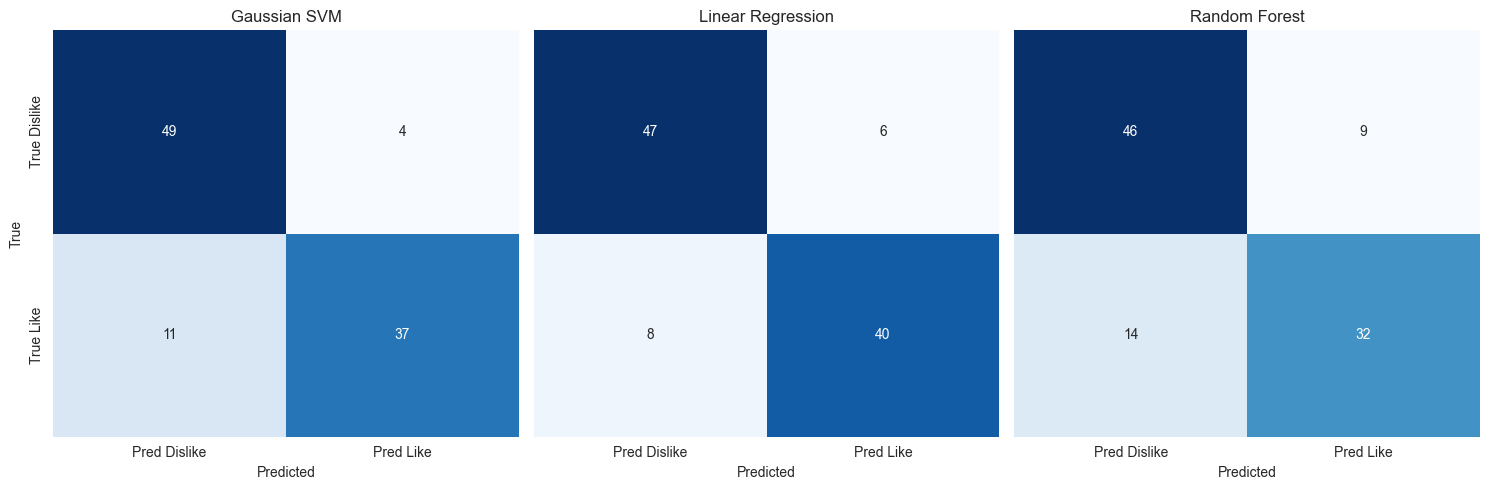

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.heatmap(cm_SVM, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes[0].set_title('Gaussian SVM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_Regr, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes[1].set_title('Linear Regression')
axes[1].set_xlabel('Predicted')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[2], xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes[2].set_title('Random Forest')
axes[2].set_xlabel('Predicted')

# Adjust layout
plt.tight_layout()
plt.savefig('ConfusionMatrix_comparison.eps', format='eps')
plt.show()

## Performance Metrics

In [61]:
metrics_table = {
    "Model": ["Gaussian SVM", "Linear Regression", "Random Forest"],
    "Accuracy (\\%)": [accuracy_svm*100, accuracy_regr*100, accuracy_rf*100],
    "Precision (\\%)": [precision_svm*100, precision_regr*100, precision_rf*100],
    "Recall (\\%)": [recall_svm*100, recall_regr*100, recall_rf*100],
    "Kappa": [kappa_svm, kappa_regr, kappa_rf]
}

# Output to latex
df_metrics = pd.DataFrame(metrics_table)
print(df_metrics)

               Model  Accuracy (\%)  Precision (\%)  Recall (\%)     Kappa
0       Gaussian SVM      85.148515       90.243902    77.083333  0.700178
1  Linear Regression      86.138614       86.956522    83.333333  0.721544
2      Random Forest      77.227723       78.048780    69.565217  0.536790


In [62]:
# Table for report
latex_table = df_metrics.to_latex(index=False, float_format="%.2f", caption="Summary of Classifier Performance", label="tab:performance_metrics", position='h')
latex_table = latex_table.replace('\\begin{table}[h]', '\\begin{table}[h]\n\\centering')
print(latex_table)

\begin{table}[h]
\centering
\caption{Summary of Classifier Performance}
\label{tab:performance_metrics}
\begin{tabular}{lrrrr}
\toprule
Model & Accuracy (\%) & Precision (\%) & Recall (\%) & Kappa \\
\midrule
Gaussian SVM & 85.15 & 90.24 & 77.08 & 0.70 \\
Linear Regression & 86.14 & 86.96 & 83.33 & 0.72 \\
Random Forest & 77.23 & 78.05 & 69.57 & 0.54 \\
\bottomrule
\end{tabular}
\end{table}

